# Data Ingest

Access data stored on s3 and explore with Athena

In [68]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

[03/16/25 20:24:52] INFO     generated new fontManager                                         ]8;id=117237;file:///opt/conda/lib/python3.11/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=220478;file:///opt/conda/lib/python3.11/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

Set up sagemaker instance

In [3]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

Verify objects in public bucket

In [4]:
!aws s3 ls s3://ads-508-final/playstation/

                           PRE achievements/
                           PRE games/
                           PRE history/
                           PRE players/
                           PRE prices/
                           PRE purchased_games/


In [5]:
# set path for public bucket
s3_playstation_path_public = 's3://ads-508-final/playstation/'

In [6]:
# set staging directory in private bucket
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [7]:
# create connection with pyathena
# EXPLORE USING ENGINE
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)

In [8]:
# define database name
database_name = "playstationaws"

In [9]:
# create database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement) 

CREATE DATABASE IF NOT EXISTS playstationaws


In [10]:
# execute query to create database
pd.read_sql(statement, conn)

""


In [11]:
# execute query to show database is present
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,default
1,playstationaws


## Fix the underlying data

The datafix notebook properly overwrites data to account for JSON arrays in the csv files

## Load data into Athena tables for analysis

Confirm process and load with `games` data, then iterate through and create remaining tables

In [114]:
# define table names based on datasets
table_names = ['achievements', 'games', 'history', 'players', 'prices', 'purchased_games']

In [115]:
# drop tables if needed
for name in table_names:
    pd.read_sql("""DROP TABLE IF EXISTS {}.{};""".format(database_name, name), conn)

In [116]:
# create table for games data
statement = """create external table if not exists {}.{} (
            game_id string,
            title string,
            platform string,
            developers ARRAY<STRING>,
            publishers ARRAY<STRING>,
            genres ARRAY<STRING>,
            supported_languages ARRAY<STRING>,
            release_date date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}games/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[1], s3_playstation_path_public
        )
print(statement)

create external table if not exists playstationaws.games (
            game_id string,
            title string,
            platform string,
            developers ARRAY<STRING>,
            publishers ARRAY<STRING>,
            genres ARRAY<STRING>,
            supported_languages ARRAY<STRING>,
            release_date date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\n'
        location 's3://ads-508-final/playstation/games/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');


In [117]:
# execute query to create table and load data
pd.read_sql(statement, conn)

""


In [118]:
# define query and check load
statement = """select * from {}.games limit 50""".format(database_name)

In [119]:
df = pd.read_sql(statement, conn)
df.head(25)

,game_id,title,platform,developers,publishers,genres,supported_languages,release_date
0,749375,Medieval Match Master,PS4,"[""[""""Erik Games""""]""]","[""[""""Erik Games""""]""]","[""[""""Puzzle""""]""]",[[]],2024-11-22
1,749839,Sunforge Solar Survival,PS4,"[""[""""GrizzlyGames""""]""]","[""[""""GrizzlyGames""""]""]",[[]],[[]],2024-11-21
2,749347,Find Love Or Die Trying,PS5,"[""[""""Sunseeker Games""""]""]","[""[""""Ratalaika Games""""]""]","[""[""""Visual Novel""""]""]",[[]],2024-11-22
3,749341,Medieval Match Master,PS4,"[""[""""Erik Games""""]""]","[""[""""Erik Games""""]""]","[""[""""Puzzle""""]""]",[[]],2024-11-22
4,749097,Bust A Block 2,PS5,"[""[""""ThiGames""""]""]","[""[""""ThiGames""""]""]","[""[""""Puzzle""""]""]",[[]],2024-11-21
5,749095,Bust A Block 2,PS4,"[""[""""ThiGames""""]""]","[""[""""ThiGames""""]""]","[""[""""Puzzle""""]""]",[[]],2024-11-21
6,746306,Trading Card Shop Simulator,PS5,"[""[""""NOSTRA GAMES""""]""]","[""[""""NOSTRA GAMES""""]""]","[""[""""Simulation""""]""]",[[]],2024-11-14
7,746215,Trading Card Shop Simulator,PS5,"[""[""""NOSTRA GAMES""""]""]","[""[""""NOSTRA GAMES""""]""]","[""[""""Simulation""""]""]",[[]],2024-11-14
8,745840,Sprawl,PS5,"[""[""""MAETH""""]""]","[""[""""Rogue Games""""]""]","[""[""""First Person Shooter""""]""]",[[]],2024-11-21
9,746216,Trading Card Shop Simulator,PS4,"[""[""""NOSTRA GAMES""""]""]","[""[""""NOSTRA GAMES""""]""]","[""[""""Simulation""""]""]",[[]],2024-11-14


In [85]:
tables = []

In [86]:
# create table for achievements data
statement_ach = """create external table if not exists {}.{} (
            achievementid string,
            gameid string,
            title string,
            description string,
            rarity string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}achievements/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[0], s3_playstation_path_public
        )

tables.append(statement_ach)

In [87]:
# create table for history data
statement_hist = """create external table if not exists {}.{} (
            playerid string,
            achievementid string,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}history/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[2], s3_playstation_path_public
        )

tables.append(statement_hist)

In [88]:
# create table for players data
statement_pla = """create external table if not exists {}.{} (
            playerid string,
            nickname string,
            country string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}players/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[3], s3_playstation_path_public
        )

tables.append(statement_pla)

In [89]:
# create table for prices data
statement_pri = """create external table if not exists {}.{} (
            gameid string,
            usd int,
            eur int,
            gbp int,
            jpy int,
            rub int,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}prices/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[4], s3_playstation_path_public
        )

tables.append(statement_pri)

In [94]:
# create table for purchased_games data
statement_pur = """create external table if not exists {}.{} (
            playerid string,
            library ARRAY<STRING>
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\\n'
        location '{}purchased_games/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');""".format(
            database_name, table_names[5], s3_playstation_path_public
        )

tables.append(statement_pur)

In [91]:
for statement in tables:
    pd.read_sql(statement, conn)
    print(f"creating table {statement}...")

creating table create external table if not exists playstationaws.achievements (
            achievementid string,
            gameid string,
            title string,
            description string,
            rarity string
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\n'
        location 's3://ads-508-final/playstation/achievements/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');...
creating table create external table if not exists playstationaws.history (
            playerid string,
            achievementid string,
            date_acquired date
        )
        row format delimited
        fields terminated by ','
        lines terminated by '\n'
        location 's3://ads-508-final/playstation/history/'
        tblproperties ('compressionType'='gzip', 'skip.header.line.count'='1');...
creating table create external table if not exists playstationaws.players (
            playerid string,


In [93]:
statement = """select * from {}.purchased_games limit 10""".format(database_name)
df = pd.read_sql(statement, conn)
df

,playerid,library
0,4340518,"[""[7687]"
1,403925,"[""[11908]"
2,321439,"[""[755124]"
3,372423,"[""[670209]"
4,1446792,"[""[457375]"
5,177410,"[""[159054]"
6,2296055,"[""[706747]"
7,2094562,"[""[417808]"
8,437161,"[""[706748]"
9,2671997,"[""[176538]"


## Data exploration and visualization

Explore tables in our database

#### Apply initial formatting for visualizations

In [75]:
sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

In [76]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

### Games

#### What are the top 25 genres by volume in the game categlog on Playstation?

In [73]:
statement = """select genres, count(*) as total
    from {}.games
    group by genres
    order by total desc
    limit 25
""".format(database_name)

df_genre = pd.read_sql(statement, conn)
df_genre

,genres,total
0,['Action'],2677
1,['Puzzle'],1605
2,['Platformer'],1450
3,['Indie'],1359
4,['Adventure'],1100
5,['eastasiasoft'],963
6,"""[""""Shoot 'em up""""]""",841
7,['Visual Novel'],604
8,['Simulation'],550
9,"""['Sports'",526


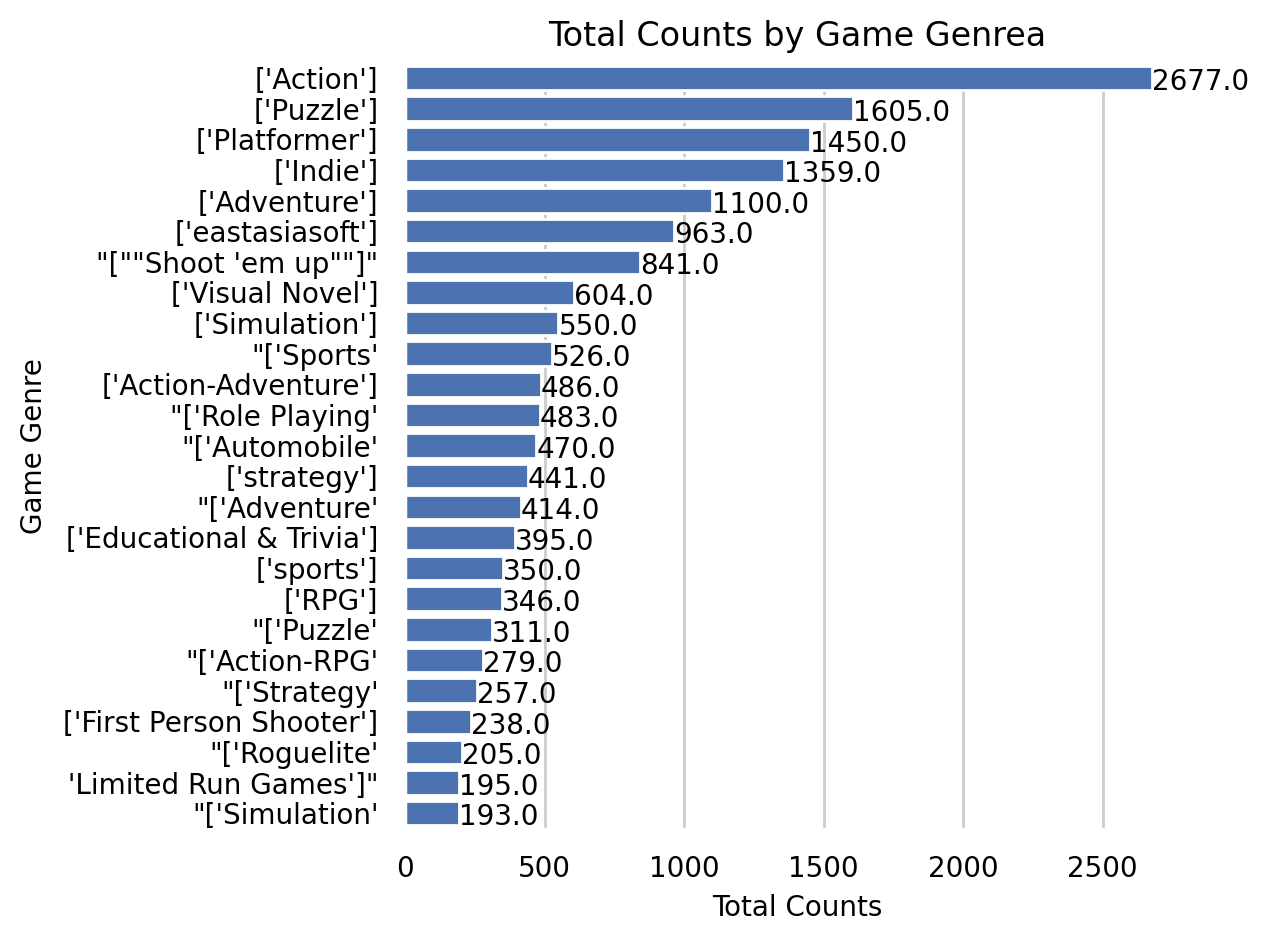

In [77]:
barplot = sns.barplot(y="genres", x="total", data=df_genre, saturation=1)

# Set title and x-axis ticks
plt.title("Total Counts by Game Genre")

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Total Counts")
plt.ylabel("Game Genre")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

#### How many games in the top 5 genres were made year? 

In [78]:
statement = """select genres, release_date
    from {}.games
    limit 25
    
""".format(database_name)

df_date = pd.read_sql(statement, conn)
df_date

,genres,release_date
0,['Puzzle'],2024-11-22
1,,2024-11-21
2,['Visual Novel'],2024-11-22
3,['Puzzle'],2024-11-22
4,['Puzzle'],2024-11-21
5,['Puzzle'],2024-11-21
6,['Simulation'],2024-11-14
7,['Simulation'],2024-11-14
8,['First Person Shooter'],2024-11-21
9,['Simulation'],2024-11-14


### Purchased Games